# Loading packages and dataset

In [1]:
using DataFrames
using CSV
using Plots
using TimeSeries
using Statistics
using Dates
source_data = DataFrame(CSV.File("./data/timeseries-country-confirmed.csv"))
country = "United States"
data_on = source_data[source_data.Country.==country, :]
cases = data_on.Cases
acc = data_on.Cumulative_cases
datatspan = findall(x -> x > 0, cases)
scatter(data_on.Date[datatspan], data_on.Cases[datatspan])

dates = data_on.Date[1]:Day(1):data_on.Date[end]
smoothing = TimeArray(dates, data_on.Cases)
length(dates)
length(data_on.Cases)
data_smooth = moving(mean, smoothing, 7)

77×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2022-05-24 to 2022-08-08
│            │ A        │
├────────────┼──────────┤
│ 2022-05-24 │ 0.5714   │
│ 2022-05-25 │ 0.7143   │
│ 2022-05-26 │ 1.2857   │
│ 2022-05-27 │ 1.8571   │
│ 2022-05-28 │ 2.0      │
│ 2022-05-29 │ 2.1429   │
│ 2022-05-30 │ 2.1429   │
│ 2022-05-31 │ 2.4286   │
│ ⋮          │ ⋮        │
│ 2022-08-02 │ 379.8571 │
│ 2022-08-03 │ 281.2857 │
│ 2022-08-04 │ 312.7143 │
│ 2022-08-05 │ 331.0    │
│ 2022-08-06 │ 331.0    │
│ 2022-08-07 │ 331.0    │
│ 2022-08-08 │ 242.8571 │

# Setting up Monkeypox model

In [79]:
using DifferentialEquations
using Plots
using Turing
using Monkeypox
N = 329500000
u0 = [N - 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
tmax = length(acc)
tspan = (0, tmax)
B = 0
μ = 0
ρ = 1 / 15
σ = 1
δ = 1 / 30
h = 0.9
ϕ = 1
p0 = [B, μ, ρ, σ, δ, h, ϕ]
odeprob = ODEProblem(monkeypoxpair, u0, tspan, p0)
sol = solve(odeprob, Vern7(), saveat=1.0:1.0:length(acc))
plot(data_on.Date[datatspan],sol[2,:])
sol[2,:][datatspan]


68-element Vector{Float64}:
 0.948915239364823
 0.9479779350256328
 1.0590932485386686
 1.0853527525765747
 1.1122813567046863
 1.1398838069952213
 1.1681730549645604
 1.1971649314861856
 1.2573255995156665
 1.2885303588190875
 ⋮
 4.96219882818852
 5.085353934371685
 5.211562891972221
 5.340903677831693
 5.748515054360956
 5.891182365576777
 6.0373899038446925
 6.187229033679837
 6.340787638299846

# Optimization

In [76]:
using DifferentialEquations, Optimization, OptimizationPolyalgorithms, OptimizationOptimJL,
  SciMLSensitivity, Zygote, Plots

# Initial condition
N = 329500000.0
u0 = [N - 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tmax = length(acc)

# Simulation interval and intermediary points
tspan = (0.0, tmax)
tsteps = 1.0:1.0:tmax

# LV equation parameter. p = [α, β, δ, γ]
B = 0.0
μ = 0.0
ρ = 1 / 15
σ = 1.0
δ = 1 / 30
h = 0.9
ϕ = 1.0
p0 = [B, μ, ρ, σ, δ, h, ϕ]
# Setup the ODE problem, then solve
prob = ODEProblem(monkeypoxpair, u0, tspan, p0)
sol = solve(prob, Tsit5())

# Plot the solution
using Plots
plot(sol)
savefig("LV_ode.png")

function loss(θ)
  B = 0.0
  μ = 0.0
  δ = 1 / 30
  ϕ = 1.0
  p = [B, μ, θ[1], θ[2], δ, θ[3], ϕ]
  sol = solve(prob, Tsit5(), p=p, saveat=tsteps)
  loss = sum(abs2, sol[10, :] .- acc)
  return loss, sol
end
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
θ0 = [0.3, 0.3, 0.8]
lb = [0.0001, 0.0001, 0.0001]
ub = [10.0, 10.0, 10.0]
optprob = Optimization.OptimizationProblem(optf, θ0,lb=lb, ub=ub)

result_ode = Optimization.solve(optprob, PolyOpt(),
  maxiters=1000)
p_min = result_ode.u
println(p_min)

[9.999999999999996, 0.07637607858851264, 9.999999999999998]


In [88]:
using Optimization
using OptimizationOptimJL
using NLopt
using SciMLSensitivity
using OptimizationPolyalgorithms
N = 329500000.0
u0 = [N - 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tmax = length(acc)
tspan = (0.0, tmax)
B = 0.0
μ = 0.0
ρ = 1 / 15
σ = 1.0
δ = 1 / 30
h = 0.9
ϕ = 1.0
p0 = [B, μ, ρ, σ, δ, h, ϕ]
prob_pred = ODEProblem(monkeypoxpair, u0, tspan, p0)
data_daily_to_learn = @view cases[datatspan]
data_to_learn = @view acc[datatspan]
function train(θ)
    B = 0.0
    μ = 0.0
    δ = 1 / 30
    ϕ = 1.0
    p0 = [B, μ, θ[1], θ[2], δ, θ[3], ϕ]
    prob_pred_train = remake(prob_pred, p=p0)
    sol = solve(prob_pred_train, Tsit5(), saveat=datatspan)
    return sol
end
function loss(θ, p)
    pred = train(θ)
    #mid = zeros(length(acc))
    #mid[2:end] =  pred[10, 1:end-1]
    #pred_daily =  pred[10, :] - mid
    #cases_learn = pred_daily[datatspan]
    #accpred = pred[10,:]
    #acc_learn =  accpred[datatspan]
    loss =  sum(abs2, (log.(acc[datatspan]) .- log.(pred[10,:]))) 
    #+ sum(abs2, (log.(data_daily_to_learn .+ 1) .- log.(cases_learn .+ 1))) # + 1e-5*sum(sum.(abs, params(ann)))
end
println(loss([0.3, 0.9, 0.8], p0))
lb = [0.0001, 0.0001, 0.0001]
ub = [1.0, 1.0, 1.0]
θ0 = [0.1, 0.1, 0.7]
loss1 = OptimizationFunction(loss, Optimization.AutoZygote())
prob = OptimizationProblem(loss1, θ0, lb=lb, ub=ub)
sol1 = Optimization.solve(prob, Optim.LBFGS(), maxiters=1000)
p_min = sol1.u
println(p_min)

196.1919224388235
[0.999999999823974, 0.15735173492170806, 0.9999999999327758]


In [50]:
@model function fitmodel(data, prob1) # data should be a Vector
    ϵ ~ InverseGamma(2, 3) # ~ is the tilde character
    ρ ~ truncated(Normal(0.4, 0.5), 0, 10)
    σ ~ truncated(Normal(0.2, 0.001), 0, 10)
    h ~ truncated(Normal(0.8, 0.001), 0, 10)
    B = 0
    μ = 0
    δ = 1 / 30
    ϕ = 1
    p = [B, μ, ρ, σ, δ, h, ϕ]
    prob = remake(prob1, p=p)
    predicted = solve(prob, Vern7(), saveat=datatspan)

    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i][10], ϵ)
    end
end
Turing.setadbackend(:forwarddiff)
N = 329500000
u0 = [N - 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
tmax = length(acc)
tspan = (0, tmax)
B = 0
μ = 0
ρ = 1 / 15
σ = 1
δ = 1 / 30
h = 0.9
ϕ = 1
p0 = [B, μ, ρ, σ, δ, h, ϕ]
prob_pred = ODEProblem(monkeypoxpair, u0, tspan, p0)
data_daily_to_learn = @view cases[datatspan]
data_to_learn = @view acc[datatspan]
model = fitmodel(data_to_learn, prob_pred)
chain = sample(model, NUTS(0.45), MCMCThreads(), 4000, 3, progress=false)#, init_theta=sol1.u)
#@save "SIR_chain_day$t_max.bason"
#p_min = [mean(chain[:ρ]), mean(chain[:σ]),chain([:h])]



┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be 

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be 

Chains MCMC chain (4000×16×3 Array{Float64, 3}):

Iterations        = 1001:1:5000
Number of chains  = 3
Samples per chain = 4000
Wall duration     = 25.03 seconds
Compute duration  = 73.2 seconds
parameters        = ϵ, ρ, σ, h
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           ϵ   369.3703   32.2621     0.2945    0.6259   2420.0166    1.0002   ⋯
           ρ     0.5833    0.0064     0.0001    0.0001   2350.7323    1.0014   ⋯
           σ     0.1999    0.0010     0.0000    0.0000   2440.9474    1.0016   ⋯
           h     0.8000    0.0010     0.0000    0.0000   6305.0876    0.9998   ⋯
                                                              

data parameter:[0.5832954413786939, 0.19993138875254915, 0.8000133205835624]


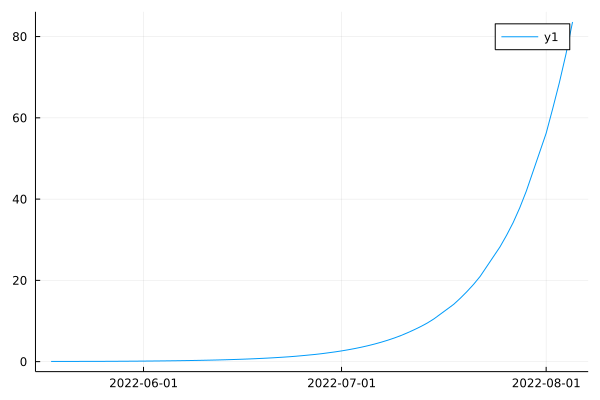

In [54]:
function train(θ)
    B = 0
    μ = 0
    δ = 1 / 30
    ϕ = 1
    p0 = [B, μ, θ[1], θ[2], δ, θ[3], ϕ]
    prob_pred_train = remake(prob_pred, p=p0)
    Array(solve(prob_pred_train, Tsit5(), saveat=datatspan))
end
p_min = [mean(chain[:ρ]), mean(chain[:σ]), mean(chain[:h])]
datespan = data_on.Date[datatspan]
println("data parameter:", p_min)
θ_0 = p_min
prediction=train(θ_0)
scatter(datespan, acc, label="Training data")
plot!(datespan,prediction[10,:], label="Real accumulated cases")

plot(datespan, prediction[5, :])


In [46]:
prob_prediction = ODEProblem(monkeypoxpair, u0, tspan_predict, p_min)
data_prediction = Array(solve(prob_prediction, Tsit5(), saveat=1))
display(plot!(data_prediction[4, :], label="Predicted accumulated cases", xlabel="Days after Feb 25", title="Ontario's Accumulated  Cases Train by $t_max days data", lw=2))
savefig("./Results_saving/SIR_Fit_Ontario_accumulated_cases_by$t_max.png")
mid = zeros(length(data_acc))
mid[2:end] = data_prediction[4, 1:end-1]
pred_daily = data_prediction[4, :] - mid
scatter(data_daily, label="Real accumulated cases")
display(plot!(pred_daily, label="Predicted Daily cases", xlabel="Days after Feb 25", title="Ontario's Daily Cases Train by $t_max days data", lw=2))
savefig("./Results_saving/SIR_Fit_Ontario_daily_cases_by$t_max.png")

UndefVarError: UndefVarError: tspan_predict not defined